In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.datasets import TranslationDataset, Multi30k, IWSLT, WMT14
from torchtext.data import Field, BucketIterator, Iterator
import spacy
import numpy as np
import random
import math
import time
from collections import defaultdict
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import itertools

In [0]:
%%capture
!python3 -m spacy download en
!python3 -m spacy download de

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
sos_token='<sos>'
eos_token='<eos>'
pad_token='<pad>'
unk_token='<unk>'

def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [0]:
TRG = Field(init_token=sos_token, 
            eos_token=eos_token,
            lower=True, 
            tokenize=tokenize_en,
            pad_token=pad_token, 
            unk_token=unk_token)

SRC = Field(init_token=sos_token, 
            eos_token=eos_token,
            lower=True, 
            tokenize=tokenize_de,
            pad_token=pad_token, 
            unk_token=unk_token)

In [0]:
%%capture
train_data, _, _ = IWSLT.splits(exts = ('.de', '.en'), 
                        fields = (SRC, TRG),
                        filter_pred=lambda x: len(x.__dict__['src']) <= 50)

test_10, valid_10, valid_12 = IWSLT.splits(exts = ('.de', '.en'), 
                                fields = (SRC, TRG),
                                train='IWSLT16.TED.tst2010',
                                test='IWSLT16.TED.dev2010',
                                validation='IWSLT16.TEDX.dev2012',
                                filter_pred=lambda x: len(x.__dict__['src']) <= 60)

test_11, test_12, test_13 = IWSLT.splits(exts = ('.de', '.en'), 
                        fields = (SRC, TRG),
                        train='IWSLT16.TED.tst2011',
                        validation='IWSLT16.TED.tst2012',
                        test='IWSLT16.TED.tst2013',
                        filter_pred=lambda x: len(x.__dict__['src']) <= 60)

test_13x, test_14x, test_14 = IWSLT.splits(exts = ('.de', '.en'), 
                        fields = (SRC, TRG),
                        train='IWSLT16.TEDX.tst2013',
                        validation='IWSLT16.TEDX.tst2014',
                        test='IWSLT16.TED.tst2014',
                        filter_pred=lambda x: len(x.__dict__['src']) <= 60)

valid_data = [valid_10, valid_12]
test_data = [test_10, test_11, test_12, test_13, test_13x, test_14x, test_14]

In [0]:
SRC.build_vocab(train_data, max_size=10000)
TRG.build_vocab(train_data, max_size=10000)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + (hid_dim * 2), output_dim)
        
    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        emb_con = torch.cat((embedded, context), dim = 2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        prediction = self.fc_out(output)
        return prediction, hidden

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs
        
    def translate(self, sentence, max_len=50, beam_width=3):
        self.eval()
        src = SRC.process([sentence]).to(device)
        context = self.encoder(src)
        hidden = context
        beams = [(0.0, [TRG.vocab.stoi[TRG.init_token]], hidden)]
        done = False
        log_smax = nn.LogSoftmax(dim=0).to(device)

        while not done:
            for i in range(len(beams)):
                p, sent, hidden = beams.pop(0)
                if len(sent) >= max_len or sent[-1] == TRG.vocab.stoi[TRG.eos_token]:
                    beams += [(p, sent, hidden)]
                    continue
                trg = torch.ones(1, dtype=torch.int64).to(device) * sent[-1]
                pred, hidden = self.decoder(trg, hidden, context)
                ll = log_smax(pred[0])
                top_ll, top_t = torch.topk(ll, k=beam_width)
                beams += [(p + ll, sent + [t], hidden) for ll, t in zip(top_ll, top_t)]
            beams = sorted(beams, reverse=True)[:beam_width]
            done = all([b[1][-1] == TRG.vocab.stoi[TRG.eos_token] or len(b[1]) >= max_len for b in beams])

        trgs = beams.pop(0)[1]
        return [TRG.vocab.itos[i] for i in trgs]

In [0]:
class EncoderBi(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return hidden[-1,:,:].unsqueeze(0)

class DecoderBi(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + (hid_dim * 2), output_dim)
        
    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        emb_con = torch.cat((embedded, context), dim = 2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        prediction = self.fc_out(output)
        return prediction, hidden

class EncoderDecoderBi(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs
        
    def translate(self, sentence, max_len=50, beam_width=3):
        self.eval()
        src = SRC.process([sentence]).to(device)
        context = self.encoder(src)
        hidden = context
        beams = [(0.0, [TRG.vocab.stoi[TRG.init_token]], hidden)]
        done = False
        log_smax = nn.LogSoftmax(dim=0).to(device)

        while not done:
            for i in range(len(beams)):
                p, sent, hidden = beams.pop(0)
                if len(sent) >= max_len or sent[-1] == TRG.vocab.stoi[TRG.eos_token]:
                    beams += [(p, sent, hidden)]
                    continue
                trg = torch.ones(1, dtype=torch.int64).to(device) * sent[-1]
                pred, hidden = self.decoder(trg, hidden, context)
                ll = log_smax(pred[0])
                top_ll, top_t = torch.topk(ll, k=beam_width)
                beams += [(p + ll, sent + [t], hidden) for ll, t in zip(top_ll, top_t)]
            beams = sorted(beams, reverse=True)[:beam_width]
            done = all([b[1][-1] == TRG.vocab.stoi[TRG.eos_token] or len(b[1]) >= max_len for b in beams])

        trgs = beams.pop(0)[1]
        return [TRG.vocab.itos[i] for i in trgs]

In [0]:
class EncoderAttn(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden.squeeze(0)

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear(enc_hid_dim + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

class DecoderAttn(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(enc_hid_dim + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear(enc_hid_dim + dec_hid_dim + emb_dim, output_dim)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        return prediction, hidden.squeeze(0)

class Search(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

        
    def translate(self, sentence, max_len=50, beam_width=3):
        self.eval()
        src = SRC.process([sentence]).to(device)
        encoder_out, hidden = self.encoder(src)
        beams = [(0.0, [TRG.vocab.stoi[TRG.init_token]], hidden)]
        done = False
        log_smax = nn.LogSoftmax(dim=0).to(device)

        while not done:
            for i in range(len(beams)):
                p, sent, hidden = beams.pop(0)
                if len(sent) >= max_len or sent[-1] == TRG.vocab.stoi[TRG.eos_token]:
                    beams += [(p, sent, hidden)]
                    continue
                trg = torch.ones(1, dtype=torch.int64).to(device) * sent[-1]
                pred, hidden = self.decoder(trg, hidden, encoder_out)
                ll = log_smax(pred[0])
                top_ll, top_t = torch.topk(ll, k=beam_width)
                beams += [(p + ll, sent + [t], hidden) for ll, t in zip(top_ll, top_t)]
            beams = sorted(beams, reverse=True)[:beam_width]
            done = all([b[1][-1] == TRG.vocab.stoi[TRG.eos_token] or len(b[1]) >= max_len for b in beams])

        trgs = beams.pop(0)[1]
        return [TRG.vocab.itos[i] for i in trgs]

In [0]:
class EncoderAttnBi(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden[1]

class AttentionBi(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear(2 * enc_hid_dim + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

class DecoderAttnBi(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        return prediction, hidden.squeeze(0)

class SearchBi(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

        
    def translate(self, sentence, max_len=50, beam_width=3):
        self.eval()
        src = SRC.process([sentence]).to(device)
        encoder_out, hidden = self.encoder(src)
        beams = [(0.0, [TRG.vocab.stoi[TRG.init_token]], hidden)]
        done = False
        log_smax = nn.LogSoftmax(dim=0).to(device)

        while not done:
            for i in range(len(beams)):
                p, sent, hidden = beams.pop(0)
                if len(sent) >= max_len or sent[-1] == TRG.vocab.stoi[TRG.eos_token]:
                    beams += [(p, sent, hidden)]
                    continue
                trg = torch.ones(1, dtype=torch.int64).to(device) * sent[-1]
                pred, hidden = self.decoder(trg, hidden, encoder_out)
                ll = log_smax(pred[0])
                top_ll, top_t = torch.topk(ll, k=beam_width)
                beams += [(p + ll, sent + [t], hidden) for ll, t in zip(top_ll, top_t)]
            beams = sorted(beams, reverse=True)[:beam_width]
            done = all([b[1][-1] == TRG.vocab.stoi[TRG.eos_token] or len(b[1]) >= max_len for b in beams])

        trgs = beams.pop(0)[1]
        return [TRG.vocab.itos[i] for i in trgs]

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
HID_DIM = 600
MAX_LENGTH = 50

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)
enc_dec = EncoderDecoder(enc, dec, device).to(device)

att = Attention(HID_DIM, HID_DIM)
enc = EncoderAttn(INPUT_DIM, ENC_EMB_DIM, HID_DIM, HID_DIM)
dec = DecoderAttn(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, att)
search = Search(enc, dec, device).to(device)

enc = EncoderBi(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = DecoderBi(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)
enc_dec_bi = EncoderDecoderBi(enc, dec, device).to(device)

att = AttentionBi(HID_DIM, HID_DIM)
enc = EncoderAttnBi(INPUT_DIM, ENC_EMB_DIM, HID_DIM, HID_DIM)
dec = DecoderAttnBi(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, att)
search_bi = SearchBi(enc, dec, device).to(device)

In [0]:
def evaluate_bleu(model, datasets, ignore_unk=False):
    total = 0.0
    count = 0.0
    for i, example in enumerate(itertools.chain(*datasets)):
        sent = SRC.process([example.src])
        if ignore_unk and SRC.vocab.stoi[SRC.unk_token] in sent:
            continue
        pred = model.translate(example.src)[1:-2]
        total += sentence_bleu([example.trg], pred, smoothing_function=SmoothingFunction().method1)
        count += 1
        if i % 200 == 199: print('.', end='')
    print('')
    return total / count
    
def bleu_summary(model, datasets, ignore_unk=False):
    overall_examples = sum([len(d) for d in datasets])
    lengths = np.zeros(overall_examples, dtype=np.int32)
    scores = np.zeros(overall_examples)

    for i, example in enumerate(itertools.chain(*datasets)):
        sent = SRC.process([example.src])
        if ignore_unk and SRC.vocab.stoi[SRC.unk_token] in sent:
            continue
        pred = model.translate(example.src)
        scores[i] = sentence_bleu([example.trg], pred, smoothing_function=SmoothingFunction().method1)
        lengths[i] = len(example.src)
        if i % 900 == 899: print('.', end='')
      
    scores = scores[lengths != 0.0]    
    lengths = lengths[lengths != 0.0]

    print('')
    means, up, lo = {}, {}, {}
    uniq_lengths, counts = np.unique(lengths, return_counts=True)
    for l, c in zip(uniq_lengths, counts):
        s = scores[lengths == l]
        means[l] = s.mean()
        up[l] = means[l] + (np.sqrt(s.var() / c) * 1.65)
        lo[l] = means[l] - (np.sqrt(s.var() / c) * 1.65)

    uniq_lengths = [l for l in sorted(uniq_lengths)]
    return uniq_lengths, [means[l] for l in uniq_lengths], [up[l] for l in uniq_lengths], [lo[l] for l in uniq_lengths]

In [0]:
enc_dec.load_state_dict(torch.load('/content/drive/My Drive/ml-mini-project/unidirectional-control/epoch-9.pt'))
search.load_state_dict(torch.load('/content/drive/My Drive/ml-mini-project/unidirectional-attention/epoch-6.pt'))
enc_dec_bi.load_state_dict(torch.load('/content/drive/My Drive/ml-mini-project/bidirectional-control/epoch-5.pt'))
search_bi.load_state_dict(torch.load('/content/drive/My Drive/ml-mini-project/bidirectional-attention/epoch-5.pt'))

<All keys matched successfully>

In [0]:
a, a_m, a_u, a_l = bleu_summary(enc_dec, test_data)
b, b_m, b_u, b_l = bleu_summary(search, test_data)
c, c_m, c_u, c_l = bleu_summary(enc_dec_bi, test_data)
d, d_m, d_u, d_l = bleu_summary(search_bi, test_data)

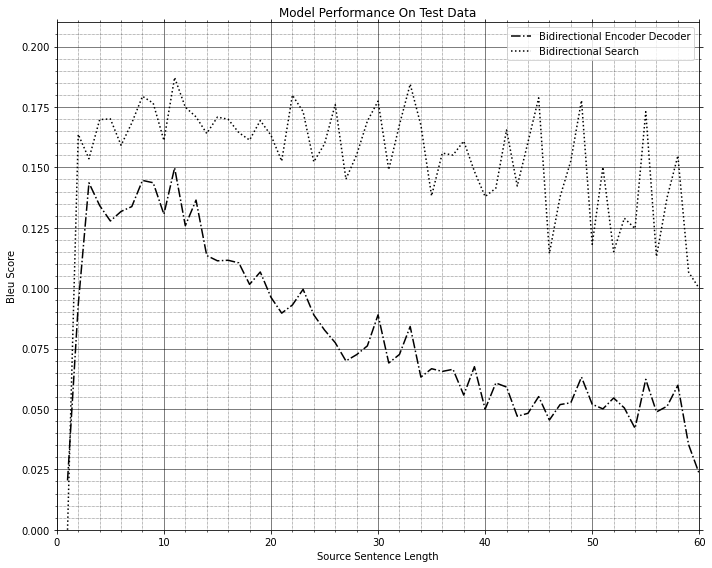

In [0]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', top='off', left='off', right='off', bottom='off')

ax.set_ylabel('Bleu Score')
ax.set_xlabel('Source Sentence Length')
# ax.plot(a, a_m, linestyle='--', color='black', label="Unidirectional Encoder Decoder")
# ax.plot(b, b_m, linestyle='-', color='black', label="Unidirectional Search")
ax.plot(c, c_m, linestyle='-.', color='black', label="Bidirectional Encoder Decoder")
ax.plot(d, d_m, linestyle=':', color='black', label="Bidirectional Search")
ax.set_title('Model Performance On Test Data')
ax.legend()
ax.set_xlim(0, 60)
ax.set_ylim(0, 0.21)

fig.tight_layout()
plt.show()

In [0]:
' '.join(search_bi.translate(SRC.tokenize('Source Sentence & und ich fragte mich, wie sie sich fühlen würden, wenn sie keinen zugang zu gesundem essen hätten, wenn sie jedes mal, wenn sie aus dem haus gehen, die negativen auswirkungen sehen, die das bestehende ernährungssystem auf ihr viertel hat.')))


"<sos> <unk> <unk> , and i asked how to feel like if you did n't have access to <unk> , if you you walked out of the house , you see the negative impacts that you have the the <unk> <unk> of the <unk> . <eos>"

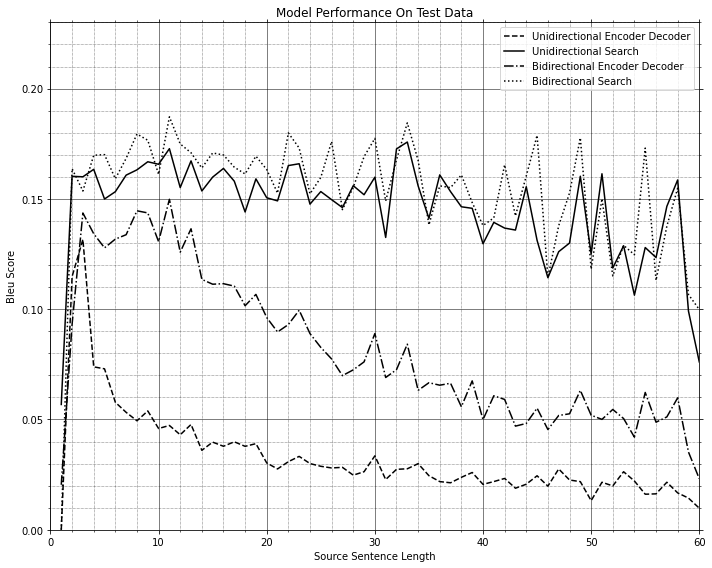

In [0]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', top='off', left='off', right='off', bottom='off')

ax.set_ylabel('Bleu Score')
ax.set_xlabel('Source Sentence Length')
ax.plot(a, a_m, linestyle='--', color='black', label="Unidirectional Encoder Decoder")
ax.plot(b, b_m, linestyle='-', color='black', label="Unidirectional Search")
ax.plot(c, c_m, linestyle='-.', color='black', label="Bidirectional Encoder Decoder")
ax.plot(d, d_m, linestyle=':', color='black', label="Bidirectional Search")
ax.set_title('Model Performance On Test Data')
ax.legend()
ax.set_xlim(0, 60)
ax.set_ylim(0, 0.23)

fig.tight_layout()
plt.show()

In [0]:
ar = evaluate_bleu(enc_dec, test_data)
br = evaluate_bleu(search, test_data)
cr = evaluate_bleu(enc_dec_bi, test_data)
dr = evaluate_bleu(search_bi, test_data)

................................................
................................................
................................................
................................................


In [0]:
list(range(5))

[0, 1, 2, 3, 4]

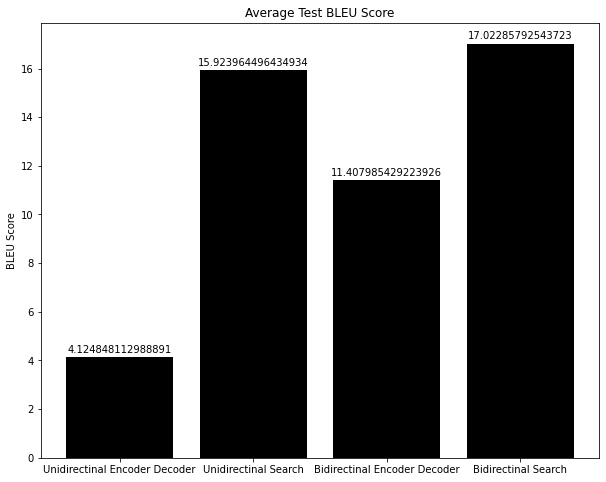

In [0]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
fig, ax = plt.subplots(figsize=(10,8))
labels = ['Unidirectinal Encoder Decoder', 'Unidirectinal Search', 'Bidirectinal Encoder Decoder', 'Bidirectinal Search']
rect = ax.bar(labels, 100 * np.array([ar, br, cr, dr]), color='black')
ax.set_ylabel('BLEU Score')
ax.set_title('Average Test BLEU Score')
autolabel(rect)

plt.show()

In [0]:
# Plot figure 3
# TODO: change train_data to test_data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
@torch.no_grad()
def translate(sentence, model, device, SRC, TRG, max_len=50):
    model.eval()
    src = SRC.process([sentence]).to(device)
    trg = torch.ones(1, dtype=torch.int64).to(device) * TRG.vocab.stoi[TRG.init_token]
    trgs, attention = [], []
    encoder_out, hidden = model.encoder(src)
    
    for t in range(max_len):
        trg, hidden = model.decoder(trg, hidden, encoder_out)
        atten = model.decoder.attention(hidden, encoder_out)

        trg = trg.argmax(1)
        trgs.append(trg)
        attention.append(atten.T)
        if trg == TRG.vocab.stoi[TRG.eos_token]: break

    trg = [TRG.vocab.itos[i] for i in trgs]
    src = [SRC.vocab.itos[i] for i in src]

    height = len(trg)
    width = len(src)
    attention = torch.cat(attention).cpu().numpy().reshape((height, width))
    return src, trg, attention


def plot_attention(src, trg, attention, name = ''):
    fig = plt.figure(figsize=(5, 5), dpi=120)
    ax = fig.add_subplot(111)
    ax.matshow(attention)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + src, rotation=60)
    ax.set_yticklabels([''] + trg) 
    plt.savefig('attention_IWSLT' + name +'.png')

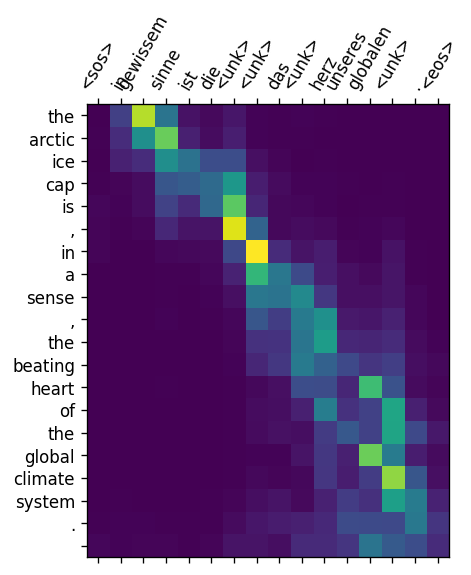

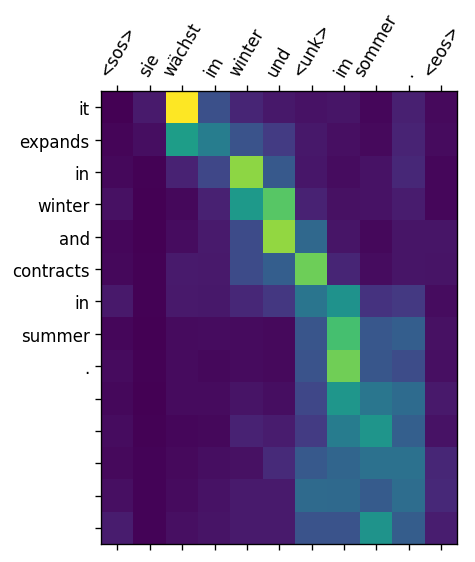

In [0]:
i = 0
for example in range(700, 800):
    # example = 6

    src, trg = valid_12[example].src, valid_12[example].trg
    if(len(src) < 15 and len(src) > 18): 
        continue
    src, pred, attention = translate(src, search_bi, device, SRC, TRG)
    plot_attention(src, trg, attention)
    i += 1
    if i > 1: break

In [0]:
c, c_m, c_u, c_l = bleu_summary(enc_dec_bi, test_data, ignore_unk=True)
d, d_m, d_u, d_l = bleu_summary(search_bi, test_data, ignore_unk=True)

.....
.....


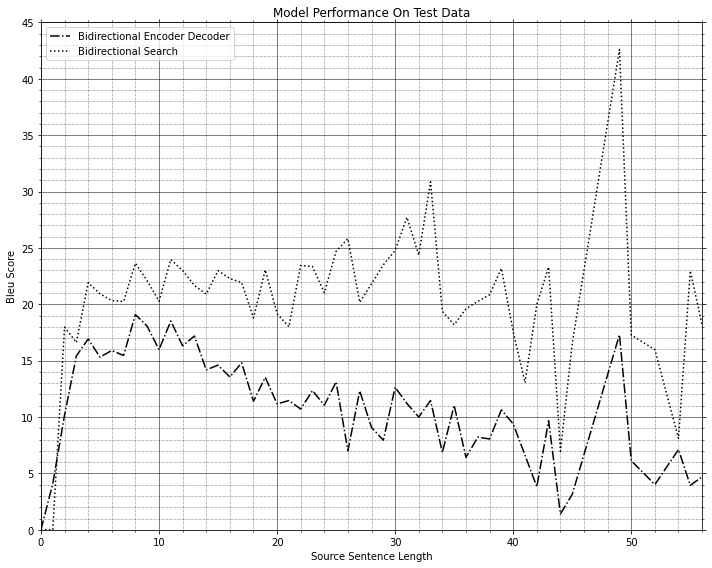

In [0]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', top='off', left='off', right='off', bottom='off')

ax.set_ylabel('Bleu Score')
ax.set_xlabel('Source Sentence Length')
ax.plot(c, [c*100 for c in c_m], linestyle='-.', color='black', label="Bidirectional Encoder Decoder")
ax.plot(d, [d*100 for d in d_m], linestyle=':', color='black', label="Bidirectional Search")
ax.set_title('Model Performance On Test Data')
ax.legend()
ax.set_xlim(0, 56)
ax.set_ylim(0, 45)

fig.tight_layout()
plt.show()

In [0]:
c = evaluate_bleu(enc_dec_bi, test_data, ignore_unk=True)
d = evaluate_bleu(search_bi, test_data, ignore_unk=True)

...................
...................


In [0]:
c, d

(0.16286076514375597, 0.22257611479923922)

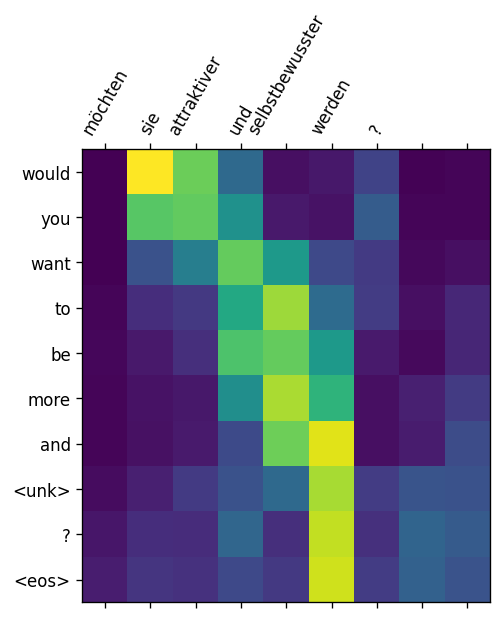

In [0]:
src, pred, attention = translate(test_11[3].src, search_bi, device, SRC, TRG)
plot_attention(test_11[3].src, pred, attention)

In [0]:
src, pred, attention = translate(['er', 'rief', ':', '"', 'die', 'taliban', 'sind', 'weng', '!', '"'], search_bi, device, SRC, TRG)
plot_attention(src, pred, attention)

['"',
 'the',
 'taliban',
 'are',
 'gone',
 '!',
 '"',
 'my',
 'father',
 'shouted',
 '.']

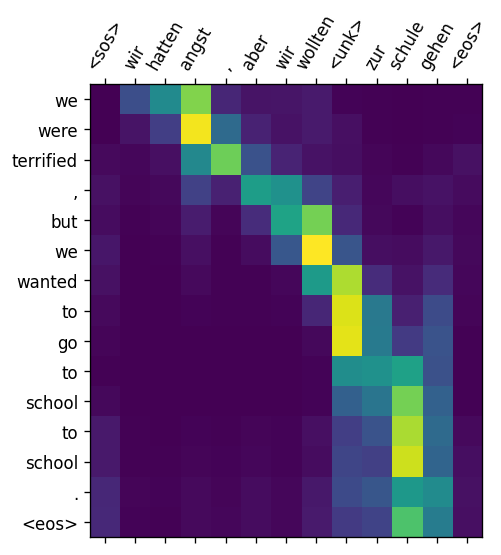

In [0]:
src, pred, attention = translate(['wir', 'hatten', 'angst', ',', 'aber', 'wir',
                                  'wollten', 'trotzder', 'zur', 'schule', 'gehen'], search_bi, device, SRC, TRG)
plot_attention(src, pred, attention)

In [0]:
pred

['we',
 'were',
 'terrified',
 ',',
 'but',
 'we',
 'wanted',
 'to',
 'go',
 'to',
 'school',
 'to',
 'school',
 '.',
 '<eos>']